In [1]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

np.set_printoptions(precision=3, suppress=True)
from dataclasses import dataclass
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import train_test_split


def display_table(df, caption, digits=3):
    df_out = df.copy()
    num_cols = df_out.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        for col in num_cols:
            df_out[col] = df_out[col].map(lambda x: f"{x:.{digits}f}" if pd.notna(x) else "")
    display(Markdown(f"**{caption}**"))
    display(df_out)



In [2]:
# loading data
data_filename = "./installment2_id03.csv"
data_df = pd.read_csv(data_filename)
test_filename = "./installment2_evaluation_data.csv"
test_df = pd.read_csv(test_filename)

# Technical Report

**Author:** Eva Song and Eton Tackett

# Data Preprocessing

To start our analysis, we first started pre-processing our data and applying the exploratory data analysis (EDA) process.

## Data Snapshot
Table 1 summarizes variable types, ranges, and missingness for the training data; no missing values are present.


In [3]:
def df_summary(df):
    summary = []

    n_rows, n_cols = df.shape

    for col in df.columns:
        s = df[col]
        info = {
            "variable": col,
            "dtype": str(s.dtype),
            "missing": int(s.isna().sum()),
            "unique": int(s.nunique(dropna=True)),
        }

        if pd.api.types.is_numeric_dtype(s):
            info.update({
                "min": float(s.min()),
                "max": float(s.max()),
                "sample_categories": ''
            })
        else:
            info.update({
                "min": np.nan,
                "max": np.nan,
                "sample_categories": ', '.join(map(str, s.dropna().unique()[:8]))
            })

        summary.append(info)

    summary_df = pd.DataFrame(summary)

    return summary_df, n_rows, n_cols

summary_df, n_rows, n_cols = df_summary(data_df)
display_table(summary_df, 'Table 1')

**Table 1**

,variable,dtype,missing,unique,min,max,sample_categories
0,PRSM,float64,0.000,2263.000,-0.975,2.977,
1,FICO,int64,0.000,299.000,482.000,850.000,
2,TotalAmtOwed,int64,0.000,2259.000,10136.000,1791524.000,
3,Volume,int64,0.000,2256.000,2393.000,8284497.000,
4,Stress,float64,0.000,2263.000,0.005,0.704,
5,Num_Delinquent,int64,0.000,6.000,3.000,8.000,
6,Num_CreditLines,int64,0.000,6.000,8.000,13.000,
7,WomanOwned,int64,0.000,2.000,0.000,1.000,
8,CorpStructure,object,0.000,4.000,,,"LLC, Corp, Partner, Sole"
9,NAICS,int64,0.000,21.000,441120.000,722514.000,


## Data Quality and Outlier Screening

We enforce basic validity rules before modeling. Table 1A shows four rows with PRSM < 0 removed; all other checks are zero. Figure 1 highlights right-tail outliers in TotalAmtOwed and Volume, motivating log transformation in the preprocessed track.


**Table 1A**

,Check,Count
0,"FICO outside [300, 850]",0.000
1,PRSM below 0,4.000
2,Stress below 0,0.000
3,Num_Delinquent > Num_CreditLines,0.000
4,Rows removed due to invalid PRSM,4.000


**Table 1A. PRSM<0 rows**

,PRSM,FICO,TotalAmtOwed,Volume,Stress,Num_Delinquent,Num_CreditLines,WomanOwned,CorpStructure,NAICS,Months
620,-0.813,698.000,51311.000,13042.000,0.328,4.000,10.000,1.000,Corp,459210.000,15.000
931,-0.975,735.000,285143.000,260634.000,0.091,4.000,12.000,0.000,Corp,722330.000,20.000
1513,-0.839,688.000,377793.000,165021.000,0.191,4.000,11.000,1.000,Sole,722330.000,18.000
1741,-0.023,679.000,38315.000,16011.000,0.199,4.000,9.000,0.000,Sole,445240.000,30.000


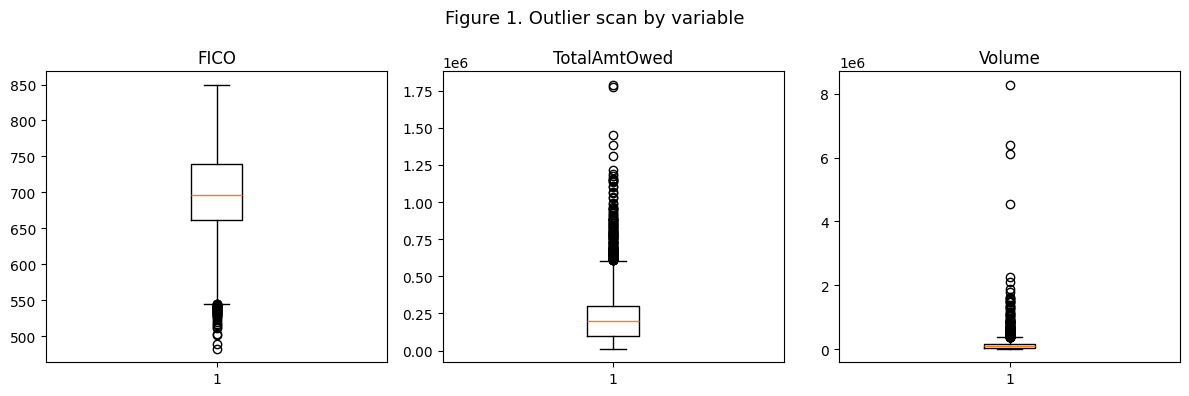

In [4]:
fico_out = data_df[(data_df['FICO'] < 300) | (data_df['FICO'] > 850)]
prsm_neg = data_df[data_df['PRSM'] < 0]
stress_neg = data_df[data_df['Stress'] < 0]
num_delinq_gt_credit = data_df[data_df['Num_Delinquent'] > data_df['Num_CreditLines']]

quality_table = pd.DataFrame({
    'Check': [
        'FICO outside [300, 850]',
        'PRSM below 0',
        'Stress below 0',
        'Num_Delinquent > Num_CreditLines',
        'Rows removed due to invalid PRSM'
    ],
    'Count': [
        len(fico_out),
        len(prsm_neg),
        len(stress_neg),
        len(num_delinq_gt_credit),
        len(prsm_neg)
    ]
})
display_table(quality_table, 'Table 1A')

if len(fico_out) > 0:
    display_table(fico_out, 'Table 1A. FICO violations')
if len(prsm_neg) > 0:
    display_table(prsm_neg, 'Table 1A. PRSM<0 rows')
if len(num_delinq_gt_credit) > 0:
    display_table(num_delinq_gt_credit, 'Table 1A. Num_Delinquent > Num_CreditLines')

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, var in enumerate(['FICO', 'TotalAmtOwed', 'Volume']):
    axes[i].boxplot(data_df[var], vert=True)
    axes[i].set_title(var)
plt.suptitle('Figure 1. Outlier scan by variable', fontsize=13)
plt.tight_layout()
plt.show()

data_df = data_df[data_df['PRSM'] >= 0]


## Feature Engineering

We create interpretable risk features. Table 1B confirms NAICS mapping coverage for train and evaluation sets (three unique 2-digit codes, zero missing). Prop_Delinquent_Credit, FICO_category, and NAICS_industry are retained for modeling.


In [5]:
data_df['Prop_Delinquent_Credit'] = data_df['Num_Delinquent'] / data_df['Num_CreditLines']
test_df['Prop_Delinquent_Credit'] = test_df['Num_Delinquent'] / test_df['Num_CreditLines']

FICO_map = {
    0: (300, 579),
    1: (580, 669),
    2: (670, 739),
    3: (740, 799),
    4: (800, 850)
}
data_df['FICO_category'] = data_df['FICO'].apply(lambda x: next((cat for cat, (low, high) in FICO_map.items() if low <= x <= high), np.nan))
test_df['FICO_category'] = test_df['FICO'].apply(lambda x: next((cat for cat, (low, high) in FICO_map.items() if low <= x <= high), np.nan))

naics_industry_map = {
    11: 'Agriculture, Forestry, Fishing and Hunting',
    21: 'Mining',
    22: 'Utilities',
    23: 'Construction',
    31: 'Manufacturing',
    32: 'Manufacturing',
    33: 'Manufacturing',
    42: 'Wholesale Trade',
    44: 'Retail Trade',
    45: 'Retail Trade',
    48: 'Transportation and Warehousing',
    49: 'Transportation and Warehousing',
    51: 'Information',
    52: 'Finance and Insurance',
    53: 'Real Estate Rental and Leasing',
    54: 'Professional, Scientific, and Technical Services',
    55: 'Management of Companies and Enterprises',
    56: 'Administrative and Support and Waste Management Services',
    61: 'Educational Services',
    62: 'Health Care and Social Assistance',
    71: 'Arts, Entertainment, and Recreation',
    72: 'Accommodation and Food Services',
    81: 'Other Services (except Public Administration)',
    92: 'Public Administration'
}

data_df['NAICS_2digit'] = (data_df['NAICS'] // 10000).astype(int)
data_df['NAICS_industry'] = data_df['NAICS_2digit'].map(naics_industry_map)

test_df['NAICS_2digit'] = (test_df['NAICS'] // 10000).astype(int)
test_df['NAICS_industry'] = test_df['NAICS_2digit'].map(naics_industry_map)

mapping_summary = pd.DataFrame({
    'Dataset': ['Training', 'Evaluation'],
    'UniqueNAICS2digitCount': [data_df['NAICS_2digit'].nunique(), test_df['NAICS_2digit'].nunique()],
    'MissingIndustryMappings': [data_df['NAICS_industry'].isna().sum(), test_df['NAICS_industry'].isna().sum()],
})
display_table(mapping_summary, 'Table 1B')




**Table 1B**

,Dataset,UniqueNAICS2digitCount,MissingIndustryMappings
0,Training,3.000,0.000
1,Evaluation,3.000,0.000


## Multicollinearity Diagnostics

Table 2a reports VIF values (maximum 2.511), indicating no multicollinearity concern. Table 2b shows low pairwise correlations, with the highest magnitude -0.775 between Prop_Delinquent_Credit and Num_CreditLines, acceptable for OLS.


In [6]:
numeric_predictors = [
    'TotalAmtOwed',
    'Volume',
    'Stress',
    'Num_CreditLines',
    'Prop_Delinquent_Credit',
    'Months'
]

X_vif = data_df[numeric_predictors]
X_vif = X_vif.assign(const=1)

vif_df = pd.DataFrame({
    'Variable': numeric_predictors,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(len(numeric_predictors))]
}).sort_values('VIF', ascending=False)
display_table(vif_df, 'Table 2a. Variance Inflation Factor')

corr_df = data_df[numeric_predictors].corr().round(3)
display_table(corr_df, 'Table 2b. Numeric predictor correlations')





**Table 2a. Variance Inflation Factor**

,Variable,VIF
4,Prop_Delinquent_Credit,2.511
3,Num_CreditLines,2.510
1,Volume,1.357
0,TotalAmtOwed,1.223
2,Stress,1.151
5,Months,1.001


**Table 2b. Numeric predictor correlations**

,TotalAmtOwed,Volume,Stress,Num_CreditLines,Prop_Delinquent_Credit,Months
TotalAmtOwed,1.000,0.392,0.031,-0.008,-0.024,0.012
Volume,0.392,1.000,-0.318,0.003,-0.015,0.004
Stress,0.031,-0.318,1.000,-0.025,0.022,0.028
Num_CreditLines,-0.008,0.003,-0.025,1.000,-0.775,-0.013
Prop_Delinquent_Credit,-0.024,-0.015,0.022,-0.775,1.000,0.007
Months,0.012,0.004,0.028,-0.013,0.007,1.000


## Distribution Check and Transform Plan

Table 3 shows strong right skew in TotalAmtOwed and Volume; Figure 2 confirms log transforms tighten their spread. We keep a baseline (raw-scale) track and a preprocessed (log-scale) track for comparison.


**Table 3. Distribution summary for continuous predictors**

,Variable,Skewness,Min,Max,Median,Mean
0,TotalAmtOwed,1.998,10136.000,1791524.000,196365.000,238990.766
1,Volume,13.882,2393.000,8284497.000,84414.000,157069.589
2,Stress,0.706,0.005,0.704,0.186,0.199
3,Num_CreditLines,0.026,8.000,13.000,10.000,10.223
4,Prop_Delinquent_Credit,0.847,0.231,1.000,0.400,0.406
5,Months,6.839,5.000,117.000,18.000,18.209


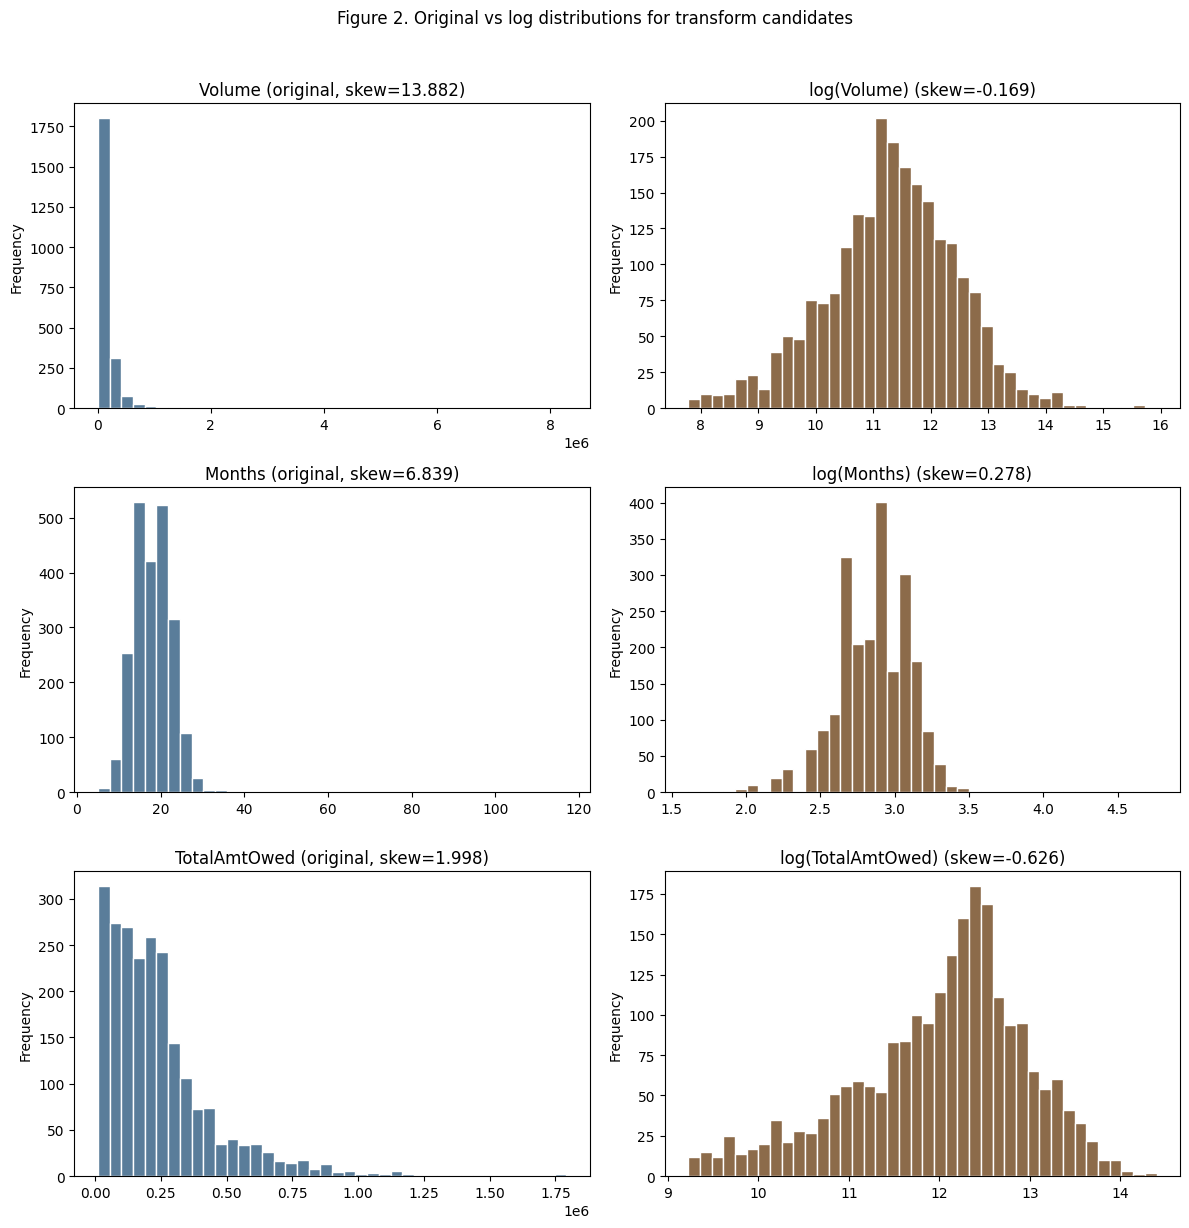

In [7]:
vars_to_check = ['TotalAmtOwed', 'Volume', 'Stress',
                 'Num_CreditLines', 'Prop_Delinquent_Credit', 'Months']

# Compute skewness
skew_df = pd.DataFrame({
    'Variable': vars_to_check,
    'Skewness': [skew(data_df[v]) for v in vars_to_check],
    'Min': [data_df[v].min() for v in vars_to_check],
    'Max': [data_df[v].max() for v in vars_to_check],
    'Median': [data_df[v].median() for v in vars_to_check],
    'Mean': [data_df[v].mean() for v in vars_to_check],
})
display_table(skew_df, 'Table 3. Distribution summary for continuous predictors')

# Plot original vs log-transformed distributions for candidate variables
candidates_for_log = ['Volume', 'Months', 'TotalAmtOwed']  # financial vars likely to be right-skewed

fig, axes = plt.subplots(len(candidates_for_log), 2, figsize=(12, 4 * len(candidates_for_log)))
for i, var in enumerate(candidates_for_log):
    vals = data_df[var]
    vals_pos = vals[vals > 0]

    axes[i, 0].hist(vals, bins=40, color='#5A7D9A', edgecolor='white')
    axes[i, 0].set_title(f'{var} (original, skew={skew(vals):.3f})')
    axes[i, 0].set_ylabel('Frequency')

    axes[i, 1].hist(np.log(vals_pos), bins=40, color='#8C6B4A', edgecolor='white')
    axes[i, 1].set_title(f'log({var}) (skew={skew(np.log(vals_pos)):.3f})')
    axes[i, 1].set_ylabel('Frequency')

fig.suptitle('Figure 2. Original vs log distributions for transform candidates', y=1.02)
plt.tight_layout()
plt.show()

# solution: log-transform for 'Volume', 'Months', 'TotalAmtOwed'
for var in candidates_for_log:
    data_df[f'log_{var}'] = np.log(data_df[var].where(data_df[var] > 0))
    test_df[f'log_{var}'] = np.log(test_df[var].where(test_df[var] > 0))







## Train/Validation Split

Table 4 records the split: 1,807 train rows, 452 dev rows, 2,500 evaluation rows, ensuring an unbiased dev set for tuning.


In [8]:
train_df, dev_df = train_test_split(data_df, test_size=0.2, random_state=628)

split_table = pd.DataFrame({
    'Dataset': ['Train', 'Dev', 'Evaluation'],
    'Rows': [train_df.shape[0], dev_df.shape[0], test_df.shape[0]],
})
display_table(split_table, 'Table 4')

**Table 4**

,Dataset,Rows
0,Train,1807.000
1,Dev,452.000
2,Evaluation,2500.000


## Response Distribution Check

Figure 3 shows raw and log PRSM distributions. PRSM is moderately right-skewed; we keep it on the original scale and rely on residual diagnostics after model fitting.


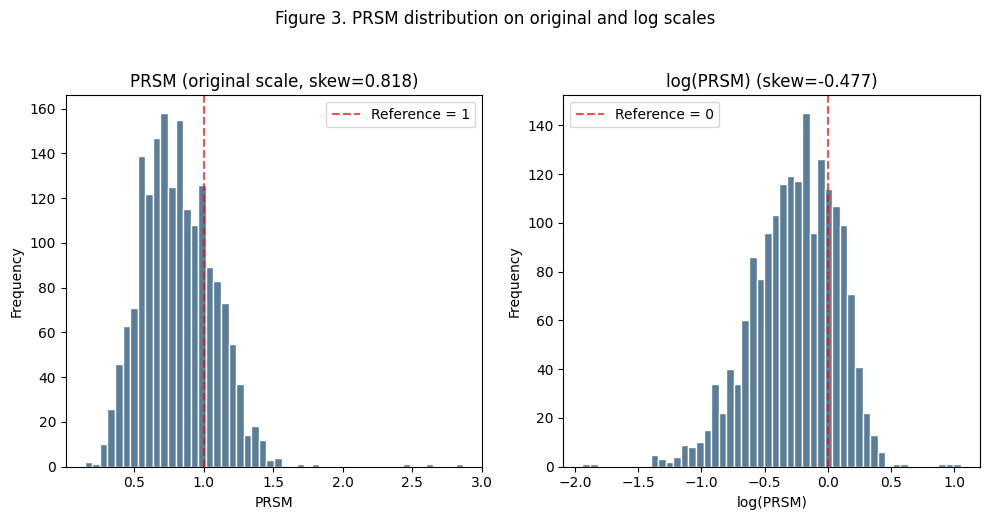

In [9]:
# Check PRSM (response) distribution for modeling diagnostics
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(train_df['PRSM'], bins=50, color='#5A7D9A', edgecolor='white')
axes[0].set_title(f'PRSM (original scale, skew={skew(train_df["PRSM"]):.3f})')
axes[0].set_xlabel('PRSM')
axes[0].set_ylabel('Frequency')
axes[0].axvline(x=1.0, color='red', linestyle='--', alpha=0.7, label='Reference = 1')
axes[0].legend()

axes[1].hist(np.log(train_df['PRSM']), bins=50, color='#5A7D9A', edgecolor='white')
axes[1].set_title(f'log(PRSM) (skew={skew(np.log(train_df["PRSM"])):.3f})')
axes[1].set_xlabel('log(PRSM)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=0.0, color='red', linestyle='--', alpha=0.7, label='Reference = 0')
axes[1].legend()

fig.suptitle('Figure 3. PRSM distribution on original and log scales', y=1.03)
plt.tight_layout()
plt.show()



## Categorical Predictors vs PRSM

Figure 4 compares PRSM across CorpStructure, WomanOwned, and NAICS_industry. Table A1 shows Retail (1,407 rows) and Accommodation/Food (400 rows) provide adequate support for dummies.


**Table A1. Industry sample sizes used in Figure 4c**

,NAICS_industry,count
0,Retail Trade,1407.000
1,Accommodation and Food Services,400.000


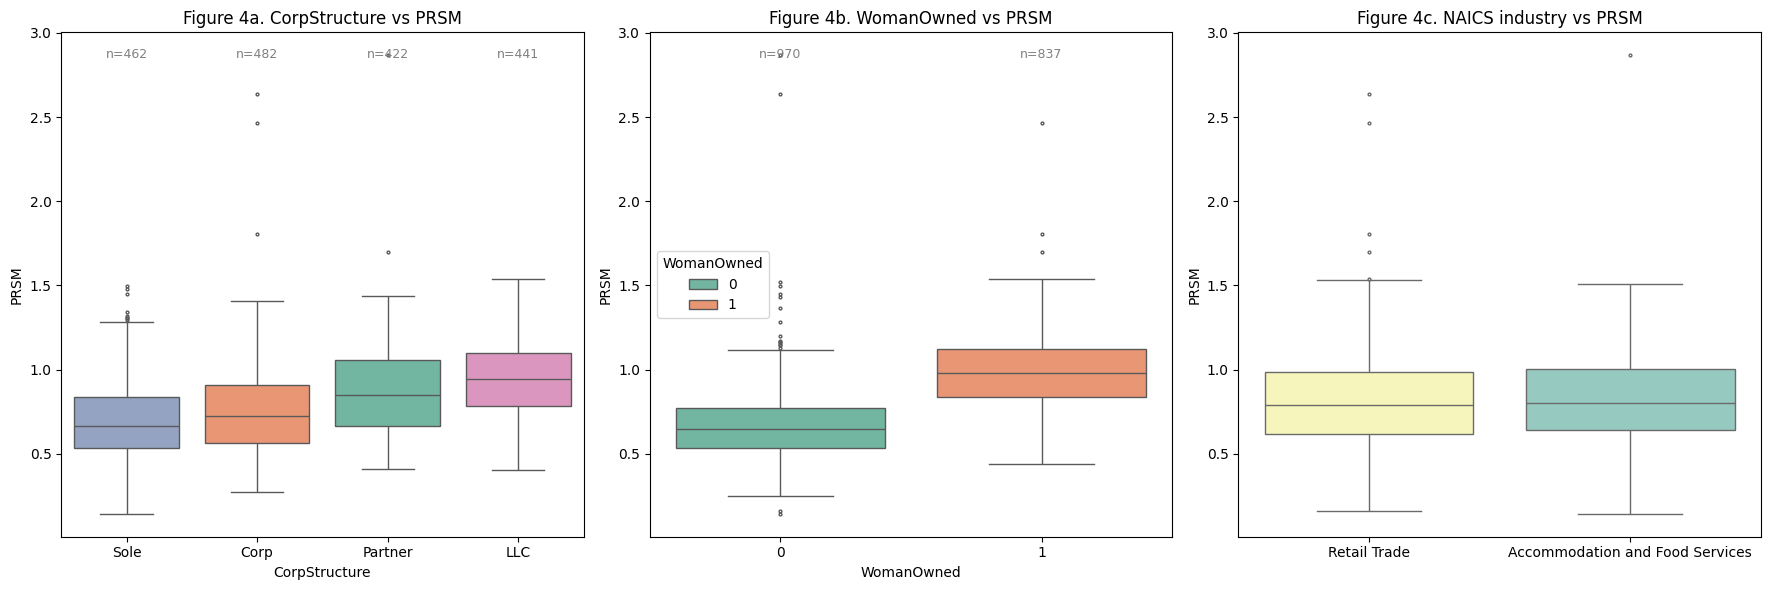

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. CorpStructure vs PRSM
order_corp = train_df.groupby('CorpStructure')['PRSM'].median().sort_values().index
sns.boxplot(data=train_df, x='CorpStructure', y='PRSM', order=order_corp, ax=axes[0],
            hue='CorpStructure', dodge=False, palette='Set2', fliersize=2)
axes[0].set_title('Figure 4a. CorpStructure vs PRSM')
for i, cat in enumerate(order_corp):
    n = (train_df['CorpStructure'] == cat).sum()
    axes[0].text(i, axes[0].get_ylim()[1] * 0.95, f'n={n}', ha='center', fontsize=9, color='gray')

# 2. WomanOwned vs PRSM
sns.boxplot(data=train_df, x='WomanOwned', y='PRSM', ax=axes[1], hue='WomanOwned', dodge=False, palette='Set2', fliersize=2)
axes[1].set_title('Figure 4b. WomanOwned vs PRSM')
for i, cat in enumerate([0, 1]):
    n = (train_df['WomanOwned'] == cat).sum()
    axes[1].text(i, axes[1].get_ylim()[1] * 0.95, f'n={n}', ha='center', fontsize=9, color='gray')

# 3. NAICS_industry vs PRSM
top_industries = train_df['NAICS_industry'].value_counts()
industry_size_table = top_industries.rename_axis("NAICS_industry").reset_index(name="count")
display_table(industry_size_table, "Table A1. Industry sample sizes used in Figure 4c")
order_ind = train_df.groupby('NAICS_industry')['PRSM'].median().sort_values().index
sns.boxplot(data=train_df, x='NAICS_industry', y='PRSM', order=order_ind, ax=axes[2],
            hue='NAICS_industry', dodge=False, palette='Set3', fliersize=2)
axes[2].set_title('Figure 4c. NAICS industry vs PRSM')
axes[2].tick_params(axis='x', rotation=0)
axes[2].set_xlabel('')

plt.tight_layout()
plt.show()

# Solution: create dummy variables for CorpStructure and NAICS_industry and NAICS
train_df = pd.concat([train_df, pd.get_dummies(train_df['CorpStructure'], prefix='CorpStructure'), pd.get_dummies(train_df['NAICS_industry'], prefix='NAICS_ind'), pd.get_dummies(train_df['NAICS'], prefix='NAICS_code')], axis=1)
dev_df = pd.concat([dev_df, pd.get_dummies(dev_df['CorpStructure'], prefix='CorpStructure'), pd.get_dummies(dev_df['NAICS_industry'], prefix='NAICS_ind'), pd.get_dummies(dev_df['NAICS'], prefix='NAICS_code')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['CorpStructure'], prefix='CorpStructure'), pd.get_dummies(test_df['NAICS_industry'], prefix='NAICS_ind'), pd.get_dummies(test_df['NAICS'], prefix='NAICS_code')], axis=1)





## FICO Category vs PRSM

Figure 5 confirms higher FICO categories correspond to lower median PRSM, supporting categorical FICO representation.


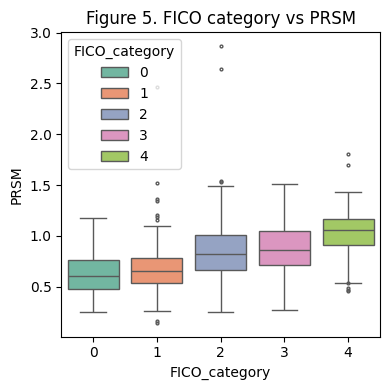

In [11]:
# FICO_category vs PRSM
fig, ax = plt.subplots(figsize=(4, 4))
order_fico = train_df.groupby('FICO_category')['PRSM'].median().sort_values().index
sns.boxplot(data=train_df, x='FICO_category', y='PRSM', order=order_fico, ax=ax,
            hue='FICO_category', dodge=False, palette='Set2', fliersize=2)
ax.set_title('Figure 5. FICO category vs PRSM')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()



## Data Preparation Summary

Table 5 lists the final modeling design, including response, transforms, categorical handling, and dropped fields.


# Data Export for Modeling

Processed train/dev/test datasets are saved for reproducible downstream modeling.


In [12]:
train_df.to_csv('./train_df.csv', index=False)
dev_df.to_csv('./dev_df.csv', index=False)
test_df.to_csv('./test_df.csv', index=False)

train_df = pd.read_csv('./train_df.csv')
dev_df = pd.read_csv('./dev_df.csv')

export_check = pd.DataFrame({
    'Dataset': ['Train', 'Dev'],
    'Shape': [str(train_df.shape), str(dev_df.shape)],
    'ColumnCount': [len(train_df.columns), len(dev_df.columns)],
})
display_table(export_check, 'Table 5A')



**Table 5A**

,Dataset,Shape,ColumnCount
0,Train,"(1807, 45)",45.000
1,Dev,"(452, 45)",45.000


In [13]:
@dataclass
class ModelMetrics:
    r2: float
    adj_r2: float
    rmse: float
    mae: float
    n_params: int
    model_name: str


def plot_residuals_diagnostics(residuals, fitted_values, model_name, color='lightblue', figsize=(8, 6)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    axes[0, 0].scatter(fitted_values, residuals, alpha=0.4, s=8)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Fitted PRSM')
    axes[0, 0].set_ylabel('Residual')
    axes[0, 0].set_title(f'{model_name}: Residual vs Fitted')
    axes[0, 0].grid(alpha=0.3)

    sm.qqplot(residuals, line='s', ax=axes[0, 1])
    axes[0, 1].set_title(f'{model_name}: Q-Q Plot')

    axes[1, 0].hist(residuals, bins=40, color=color, edgecolor='black')
    axes[1, 0].set_xlabel('Residual')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title(f'{model_name}: Residual Distribution')

    std_resid = residuals / residuals.std()
    axes[1, 1].scatter(fitted_values, np.sqrt(np.abs(std_resid)), alpha=0.4, s=8)
    axes[1, 1].set_xlabel('Fitted PRSM')
    axes[1, 1].set_ylabel('Sqrt(|Standardized Residual|)')
    axes[1, 1].set_title(f'{model_name}: Scale-Location')
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def _quantile_pi(y_pred, residuals, alpha=0.05):
    q = np.quantile(np.abs(np.asarray(residuals)), 1 - alpha)
    return y_pred - q, y_pred + q


def validate_on_dev_set(model, X_dev, y_dev, model_name, color='blue', model_type='OLS', train_residuals=None):
    y_pred = model.predict(X_dev)
    y_dev_arr = np.asarray(y_dev)

    rmse = np.sqrt(np.mean((y_dev_arr - y_pred) ** 2))
    mae = np.mean(np.abs(y_dev_arr - y_pred))

    if model_type == 'OLS' and hasattr(model, 'get_prediction'):
        try:
            pred_summary = model.get_prediction(X_dev).summary_frame(alpha=0.05)
            pi_lower = pred_summary['obs_ci_lower'].to_numpy()
            pi_upper = pred_summary['obs_ci_upper'].to_numpy()
            pi_method = 'OLS observation interval'
        except Exception:
            residual_source = train_residuals if train_residuals is not None else getattr(model, 'resid', y_dev_arr - y_pred)
            pi_lower, pi_upper = _quantile_pi(y_pred, residual_source, alpha=0.05)
            pi_method = 'Residual-quantile fallback'
    else:
        residual_source = train_residuals if train_residuals is not None else y_dev_arr - y_pred
        pi_lower, pi_upper = _quantile_pi(y_pred, residual_source, alpha=0.05)
        pi_method = 'Residual-quantile interval'

    coverage = np.mean((y_dev_arr >= pi_lower) & (y_dev_arr <= pi_upper))

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.scatter(y_dev_arr, y_pred, alpha=0.4, s=8, color=color)
    ax.plot([y_dev_arr.min(), y_dev_arr.max()], [y_dev_arr.min(), y_dev_arr.max()], 'r--', lw=2, label='Perfect fit line')
    ax.set_xlabel('Actual PRSM (Dev)')
    ax.set_ylabel('Predicted PRSM')
    ax.set_title(f'{model_name}: Dev Actual vs Predicted')
    ax.legend()
    plt.tight_layout()
    plt.show()

    dev_metrics = {
        'Model': model_name,
        'DevRMSE': rmse,
        'DevMAE': mae,
        'PI95Coverage': coverage,
        'IntervalMethod': pi_method,
    }
    return rmse, mae, coverage, dev_metrics


def fit_ols_model(X_train, y_train, model_name='OLS Model'):
    if 'const' not in X_train.columns:
        X_train = sm.add_constant(X_train)

    model = sm.OLS(y_train, X_train).fit()

    r2 = model.rsquared
    adj_r2 = model.rsquared_adj
    n_params = int(model.df_model)

    train_metrics = {
        'Model': model_name,
        'TrainR2': r2,
        'TrainAdjR2': adj_r2,
        'ParamCount': n_params,
    }
    return model, {'r2': r2, 'adj_r2': adj_r2, 'n_params': n_params, 'train_metrics': train_metrics}


def _cv_rmse(X, y, cv_splitter):
    model = LinearRegression()
    rmse_scores = -cross_val_score(
        model,
        X,
        y,
        scoring='neg_root_mean_squared_error',
        cv=cv_splitter,
    )
    return float(np.mean(rmse_scores))


def backward_stepwise_selection(X_train, y_train, threshold_p=0.05, cv=5, random_state=42, min_improvement=1e-4):
    use_const = 'const' in X_train.columns
    predictors = [c for c in X_train.columns if c != 'const']

    if len(predictors) == 0:
        raise ValueError('No predictors available for stepwise selection.')

    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    current_rmse = _cv_rmse(X_train[predictors], y_train, cv_splitter)
    initial_rmse = current_rmse
    initial_count = len(predictors)

    removed_features = []

    while len(predictors) > 1:
        candidate_results = []
        for feature in predictors:
            candidate_predictors = [p for p in predictors if p != feature]
            rmse_candidate = _cv_rmse(X_train[candidate_predictors], y_train, cv_splitter)
            candidate_results.append((feature, rmse_candidate))

        feature_to_remove, best_candidate_rmse = min(candidate_results, key=lambda x: x[1])

        if current_rmse - best_candidate_rmse > min_improvement:
            predictors.remove(feature_to_remove)
            removed_features.append(feature_to_remove)
            current_rmse = best_candidate_rmse
        else:
            break

    X_final = X_train[predictors].copy()
    if use_const:
        X_final = sm.add_constant(X_final, has_constant='add')

    final_model = sm.OLS(y_train, X_final).fit()

    stepwise_summary = pd.DataFrame({
        'InitialPredictorCount': [initial_count],
        'FinalPredictorCount': [len(predictors)],
        'InitialCVRMSE': [initial_rmse],
        'FinalCVRMSE': [current_rmse],
        'RemovedPredictors': [', '.join(removed_features) if removed_features else 'None'],
    })

    return predictors, final_model, stepwise_summary


def fit_lasso_model(X_train, y_train, features_list, model_name='LASSO Model'):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    cv_splitter = KFold(n_splits=5, shuffle=True, random_state=42)
    lasso_cv = LassoCV(cv=cv_splitter, random_state=42, max_iter=10000, n_alphas=100)
    lasso_cv.fit(X_train_scaled, y_train)

    optimal_alpha = float(lasso_cv.alpha_)

    y_pred = lasso_cv.predict(X_train_scaled)
    r2 = r2_score(y_train, y_pred)
    n = len(y_train)
    p = int(np.sum(lasso_cv.coef_ != 0))

    if n - p - 1 > 0:
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        adj_r2 = np.nan

    lasso_coefs = pd.DataFrame({'Predictor': features_list, 'Coefficient': lasso_cv.coef_})
    lasso_coefs['AbsCoefficient'] = np.abs(lasso_coefs['Coefficient'])
    lasso_coefs = lasso_coefs.sort_values('AbsCoefficient', ascending=False)

    residuals = np.asarray(y_train) - y_pred

    train_metrics = {
        'Model': model_name,
        'TrainR2': r2,
        'TrainAdjR2': adj_r2,
        'ParamCount': p,
        'OptimalAlpha': optimal_alpha,
    }

    return lasso_cv, scaler, {
        'r2': r2,
        'adj_r2': adj_r2,
        'n_params': p,
        'optimal_alpha': optimal_alpha,
        'coefficients': lasso_coefs,
        'train_residuals': residuals,
        'train_metrics': train_metrics,
    }



# Model Development

We evaluate six models: three baseline (no log) and three preprocessed (log). Each model block reports training fit, diagnostics, and dev-set accuracy; interpretations are summarized in markdown and in the final comparison.


**Table M0A. Model 0 training metrics**

,Model,TrainR2,TrainAdjR2,ParamCount
0,"Model 0 Baseline OLS, raw predictors",0.743,0.741,12.000


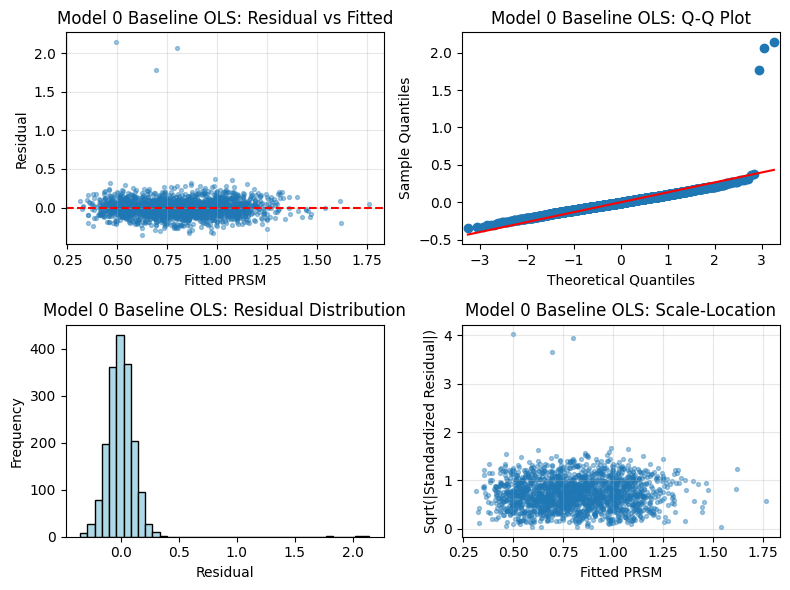

In [14]:
# Model 0: Baseline OLS (without log transformation)
base_predictors = ['FICO_category', 'TotalAmtOwed', 'Volume', 'Stress', 'Num_CreditLines', 'Prop_Delinquent_Credit','WomanOwned', 'Months', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'NAICS_ind_Retail Trade']

X_train_base = train_df[base_predictors].copy().astype(float)
X_train_base_with_const = sm.add_constant(X_train_base)
X_dev_base = dev_df[base_predictors].copy().astype(float)
X_dev_base_with_const = sm.add_constant(X_dev_base)
y_train = train_df['PRSM'].astype(float)
y_dev = dev_df['PRSM'].astype(float)

model_baselineOLS, metrics_baselineOLS = fit_ols_model(X_train_base_with_const, y_train, 'Model 0 Baseline OLS, raw predictors')

baselineOLS_r2 = metrics_baselineOLS['r2']
baselineOLS_adj_r2 = metrics_baselineOLS['adj_r2']

model0_train_table = pd.DataFrame([metrics_baselineOLS['train_metrics']])
display_table(model0_train_table, 'Table M0A. Model 0 training metrics')

residuals_baselineOLS = model_baselineOLS.resid
fitted_baselineOLS = model_baselineOLS.fittedvalues
plot_residuals_diagnostics(residuals_baselineOLS, fitted_baselineOLS, 'Model 0 Baseline OLS', color='lightblue')


### Baseline OLS Review and Outlier Trimming

```
PRSM ~ FICO_category + TotalAmtOwed + Volume + Stress + Num_CreditLines + Prop_Delinquent_Credit+ WomanOwned + Months + CorpStructure_Corp + CorpStructure_LLC + CorpStructure_Partner + NAICS_Retail Trade
```

Diagnostics flagged large residuals; trimming |residual| > 0.5 (Table M0B/C) leaves 1,804 rows. Trimmed Model 0 achieves dev RMSE 0.217 and PI95 coverage 94.9% (Table M0E), and serves as the no-log benchmark. Residual plots show homoscedasticity improves after trimming.


**Table M0B. Outlier screening summary**

,Metric,Value
0,ResidualThreshold,0.500
1,OutlierCount,3.000
2,TrainRowsBeforeTrim,1807.000


**Table M0C. Largest residual outliers (top 20)**

,Index,Actual_PRSM,Predicted_PRSM,Residual,Abs_Residual
0,49.000,2.640,0.497,2.143,2.143
1,866.000,2.867,0.798,2.069,2.069
2,1152.000,2.467,0.693,1.774,1.774


**Table M0D. Model 0 trimmed training metrics**

,Model,TrainR2,TrainAdjR2,ParamCount
0,Model 0 Trimmed OLS,0.826,0.825,12.000


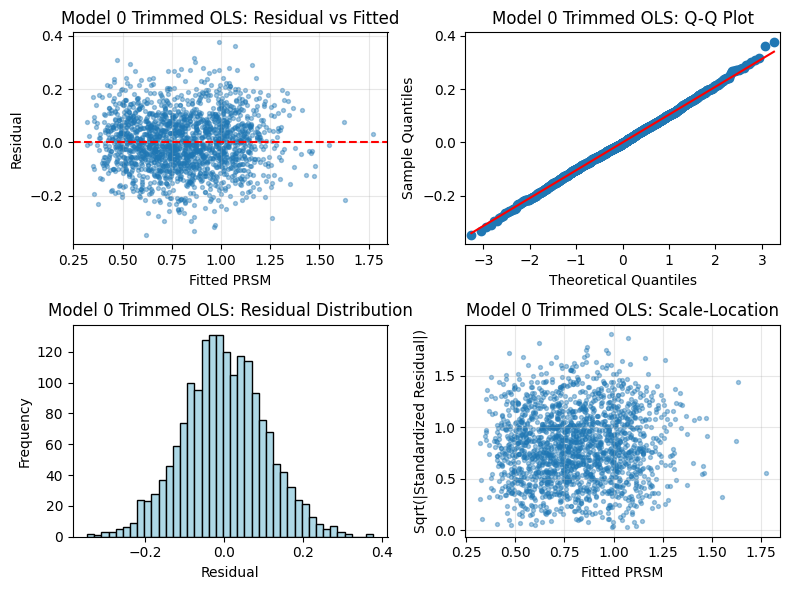

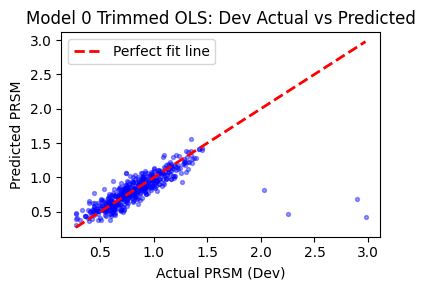

**Table M0E. Model 0 dev metrics**

,Model,DevRMSE,DevMAE,PI95Coverage,IntervalMethod
0,Model 0 Trimmed OLS,0.217,0.103,0.949,OLS observation interval


In [15]:
# Model 0 refinement: outlier trimming based on residual threshold
outlier_threshold = 0.5
abs_residuals = np.abs(residuals_baselineOLS)
outlier_mask = abs_residuals > outlier_threshold
outlier_indices = np.where(outlier_mask)[0]

model0_outlier_summary = pd.DataFrame({
    'Metric': ['ResidualThreshold', 'OutlierCount', 'TrainRowsBeforeTrim'],
    'Value': [outlier_threshold, len(outlier_indices), len(X_train_base)],
})
display_table(model0_outlier_summary, 'Table M0B. Outlier screening summary')

if len(outlier_indices) > 0:
    outlier_data = pd.DataFrame({
        'Index': outlier_indices,
        'Actual_PRSM': y_train.iloc[outlier_indices].values,
        'Predicted_PRSM': fitted_baselineOLS.iloc[outlier_indices].values,
        'Residual': residuals_baselineOLS.iloc[outlier_indices].values,
        'Abs_Residual': abs_residuals.iloc[outlier_indices].values
    }).sort_values('Abs_Residual', ascending=False).head(20)
else:
    outlier_data = pd.DataFrame(columns=['Index', 'Actual_PRSM', 'Predicted_PRSM', 'Residual', 'Abs_Residual'])
display_table(outlier_data, 'Table M0C. Largest residual outliers (top 20)')

inlier_mask = (~outlier_mask).values
X_train_base_del = X_train_base[inlier_mask].copy().astype(float)
X_train_base_with_const_del = sm.add_constant(X_train_base_del)
y_train_base_del = y_train[inlier_mask].copy().astype(float)

model_baselineOLS_del, metrics_baselineOLS_del = fit_ols_model(X_train_base_with_const_del, y_train_base_del, 'Model 0 Trimmed OLS')

baselineOLS_del_r2 = metrics_baselineOLS_del['r2']
baselineOLS_del_adj_r2 = metrics_baselineOLS_del['adj_r2']

model0_trim_train_table = pd.DataFrame([metrics_baselineOLS_del['train_metrics']])
display_table(model0_trim_train_table, 'Table M0D. Model 0 trimmed training metrics')

residuals_baselineOLS_del = model_baselineOLS_del.resid
fitted_baselineOLS_del = model_baselineOLS_del.fittedvalues
plot_residuals_diagnostics(residuals_baselineOLS_del, fitted_baselineOLS_del, 'Model 0 Trimmed OLS', color='lightblue')

rmse_baselineOLS_del, mae_baselineOLS_del, coverage_baselineOLS_del, metrics_m0_dev = validate_on_dev_set(
    model_baselineOLS_del, X_dev_base_with_const, y_dev, 'Model 0 Trimmed OLS', 'blue', model_type='OLS')

model0_dev_table = pd.DataFrame([metrics_m0_dev])
display_table(model0_dev_table, 'Table M0E. Model 0 dev metrics')


## Model 1: Baseline LASSO

```
PRSM ~ FICO_category + TotalAmtOwed + Volume + Stress + Num_CreditLines + Prop_Delinquent_Credit+ WomanOwned + Months + CorpStructure_Corp + CorpStructure_LLC + CorpStructure_Partner + NAICS_Retail Trade
```

L1 shrinkage on raw predictors retains 12 non-zero terms (Table M1B). Dev RMSE 0.217 and PI95 coverage 95.1% (Table M1C) match Model 0; no gain in error but coefficients highlight dominant dummies (WomanOwned, CorpStructure). Use Model 1 when a sparse linear form is desired without log transforms.


**Table M1A. Model 1 training metrics**

,Model,TrainR2,TrainAdjR2,ParamCount,OptimalAlpha
0,"Model 1 Baseline LASSO, raw predictors",0.826,0.825,12.000,0.001


**Table M1B. Model 1 non-zero coefficients**

,Predictor,Coefficient,AbsCoefficient
6,WomanOwned,0.139,0.139
9,CorpStructure_LLC,0.104,0.104
1,TotalAmtOwed,0.100,0.100
10,CorpStructure_Partner,0.073,0.073
0,FICO_category,0.054,0.054
3,Stress,0.050,0.050
7,Months,0.013,0.013
8,CorpStructure_Corp,0.012,0.012
2,Volume,-0.003,0.003
11,NAICS_ind_Retail Trade,-0.002,0.002


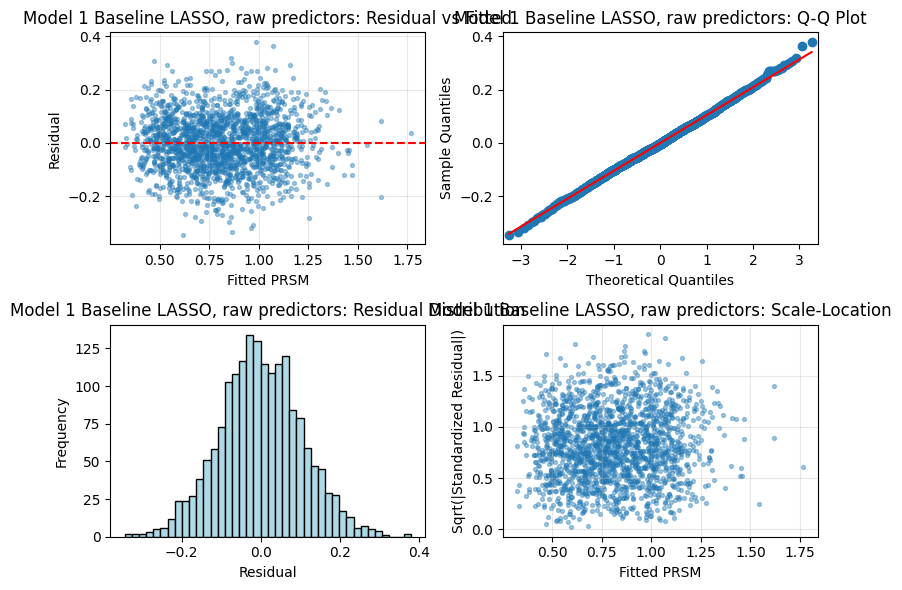

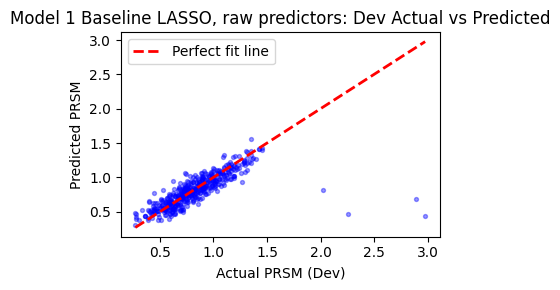

**Table M1C. Model 1 dev metrics**

,Model,DevRMSE,DevMAE,PI95Coverage,IntervalMethod
0,"Model 1 Baseline LASSO, raw predictors",0.217,0.103,0.951,Residual-quantile interval


In [16]:
# Model 1: Baseline LASSO (without log transformation)
model_baselineLASSO, scaler_baselineLASSO, metrics_baselineLASSO = fit_lasso_model(
    X_train_base_del, y_train_base_del, base_predictors, 'Model 1 Baseline LASSO, raw predictors'
)

baselineLASSO_r2 = metrics_baselineLASSO['r2']
baselineLASSO_adj_r2 = metrics_baselineLASSO['adj_r2']
lasso_coefs_baselineLASSO = metrics_baselineLASSO['coefficients']

model1_train_table = pd.DataFrame([metrics_baselineLASSO['train_metrics']])
display_table(model1_train_table, 'Table M1A. Model 1 training metrics')

model1_coef_table = lasso_coefs_baselineLASSO[lasso_coefs_baselineLASSO['Coefficient'] != 0].copy()
display_table(model1_coef_table, 'Table M1B. Model 1 non-zero coefficients')

X_train_lasso_scaled = scaler_baselineLASSO.transform(X_train_base_del)
y_pred_train_baselineLASSO = model_baselineLASSO.predict(X_train_lasso_scaled)

residuals_baselineLASSO = y_train_base_del - y_pred_train_baselineLASSO
fitted_baselineLASSO = y_pred_train_baselineLASSO
plot_residuals_diagnostics(residuals_baselineLASSO, fitted_baselineLASSO, 'Model 1 Baseline LASSO, raw predictors', color='lightblue')

X_dev_lasso_scaled = scaler_baselineLASSO.transform(X_dev_base)
rmse_baselineLASSO, mae_baselineLASSO, coverage_baselineLASSO, metrics_m1_dev = validate_on_dev_set(
    model_baselineLASSO, X_dev_lasso_scaled, y_dev, 'Model 1 Baseline LASSO, raw predictors', 'blue', 
    model_type='LASSO', train_residuals=metrics_baselineLASSO['train_residuals'])

model1_dev_table = pd.DataFrame([metrics_m1_dev])
display_table(model1_dev_table, 'Table M1C. Model 1 dev metrics')


## Model 2: Baseline Stepwise OLS

```
PRSM ~ FICO_category + TotalAmtOwed + Volume + Stress + Num_CreditLines + Prop_Delinquent_Credit+ WomanOwned + Months + CorpStructure_Corp + CorpStructure_LLC + CorpStructure_Partner + NAICS_Retail Trade
```

CV-based backward selection removed no predictors (Table M2B/C); dev RMSE 0.217 (Table M2D) equals Models 0?1. Conclusion: stepwise adds complexity without parsimony benefit on raw predictors.


**Table M2A. Model 2 training metrics**

,Model,TrainR2,TrainAdjR2,ParamCount
0,Model 2 Baseline Stepwise OLS,0.826,0.825,12.000


**Table M2B. Model 2 stepwise CV summary**

,InitialPredictorCount,FinalPredictorCount,InitialCVRMSE,FinalCVRMSE,RemovedPredictors
0,12.000,12.000,0.105,0.105,None


**Table M2C. Model 2 retained coefficients**

,predictor,coef
0,FICO_category,0.056
1,TotalAmtOwed,0.000
2,Volume,-0.000
3,Stress,0.471
4,Num_CreditLines,0.000
5,Prop_Delinquent_Credit,-0.011
6,WomanOwned,0.279
7,Months,0.002
8,CorpStructure_Corp,0.032
9,CorpStructure_LLC,0.246


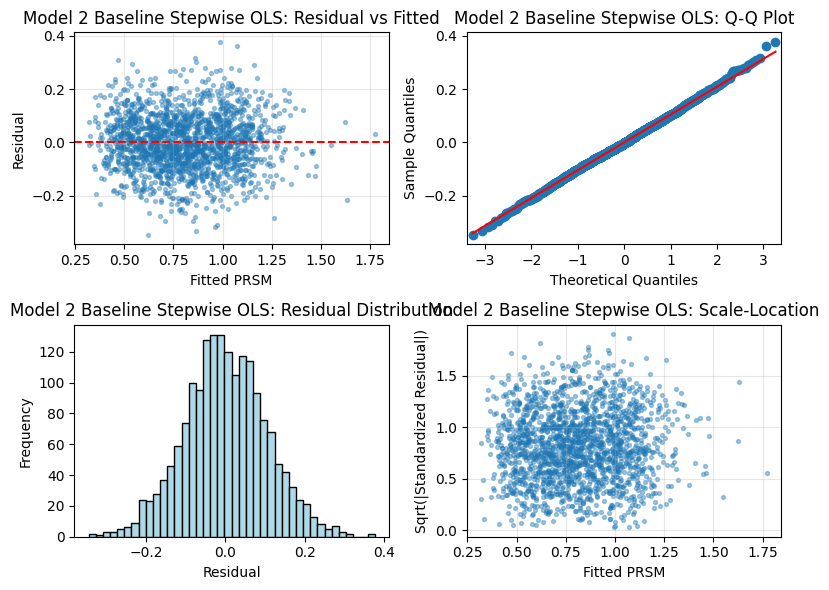

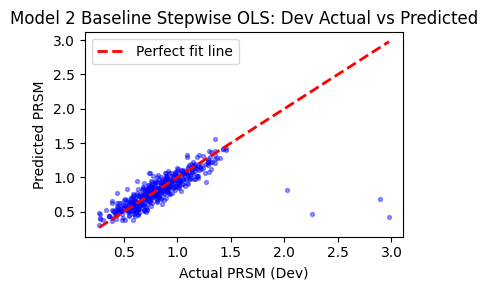

**Table M2D. Model 2 dev metrics**

,Model,DevRMSE,DevMAE,PI95Coverage,IntervalMethod
0,Model 2 Baseline Stepwise OLS,0.217,0.103,0.949,OLS observation interval


In [17]:
# Model 2: Baseline Stepwise OLS (without log transformation)
stepwise_predictors_baselineStep, model_baselineStep, stepwise_summary_baseline = backward_stepwise_selection(
    X_train_base_with_const_del, y_train_base_del, threshold_p=0.05)

baselineStep_r2 = model_baselineStep.rsquared
baselineStep_adj_r2 = model_baselineStep.rsquared_adj

model2_train_table = pd.DataFrame([{
    'Model': 'Model 2 Baseline Stepwise OLS',
    'TrainR2': baselineStep_r2,
    'TrainAdjR2': baselineStep_adj_r2,
    'ParamCount': int(model_baselineStep.df_model),
}])
display_table(model2_train_table, 'Table M2A. Model 2 training metrics')

stepwise_summary_baseline = stepwise_summary_baseline
stepwise_summary_baseline['InitialCVRMSE'] = stepwise_summary_baseline['InitialCVRMSE'].astype(float)
stepwise_summary_baseline['FinalCVRMSE'] = stepwise_summary_baseline['FinalCVRMSE'].astype(float)
display_table(stepwise_summary_baseline, 'Table M2B. Model 2 stepwise CV summary')

stepwise_coef_table = (
    model_baselineStep.params
    .drop('const', errors='ignore')
    .rename('coef')
    .reset_index()
    .rename(columns={'index': 'predictor'})
)
display_table(stepwise_coef_table, 'Table M2C. Model 2 retained coefficients')

residuals_baselineStep = model_baselineStep.resid
fitted_baselineStep = model_baselineStep.fittedvalues
plot_residuals_diagnostics(residuals_baselineStep, fitted_baselineStep, 'Model 2 Baseline Stepwise OLS', color='lightblue')

X_dev_baselineStep = dev_df[stepwise_predictors_baselineStep].copy().astype(float)
X_dev_baselineStep = sm.add_constant(X_dev_baselineStep)

rmse_baselineStep, mae_baselineStep, coverage_baselineStep, metrics_m2_dev = validate_on_dev_set(
    model_baselineStep, X_dev_baselineStep, y_dev, 'Model 2 Baseline Stepwise OLS', 'blue', model_type='OLS')

model2_dev_table = pd.DataFrame([metrics_m2_dev])
display_table(model2_dev_table, 'Table M2D. Model 2 dev metrics')


## Model 3: Preprocessed OLS
```
PRSM ~ FICO_category + log_TotalAmtOwed + log_Volume + Stress + log_Months + 
        Num_CreditLines + Prop_Delinquent_Credit  + WomanOwned + 
       CorpStructure_Corp + CorpStructure_LLC + CorpStructure_Partner + NAICS_Retail Trade
```

Using log-transformed scale variables, trimmed Model 3 reaches dev RMSE 0.222 (Table M3E), worse than baseline track. Residual plots improve shape but error rises; logs alone do not outperform raw-scale OLS here.


**Table M3A. Model 3 training metrics**

,Model,TrainR2,TrainAdjR2,ParamCount
0,"Model 3 Preprocessed OLS, log predictors",0.700,0.698,12.000


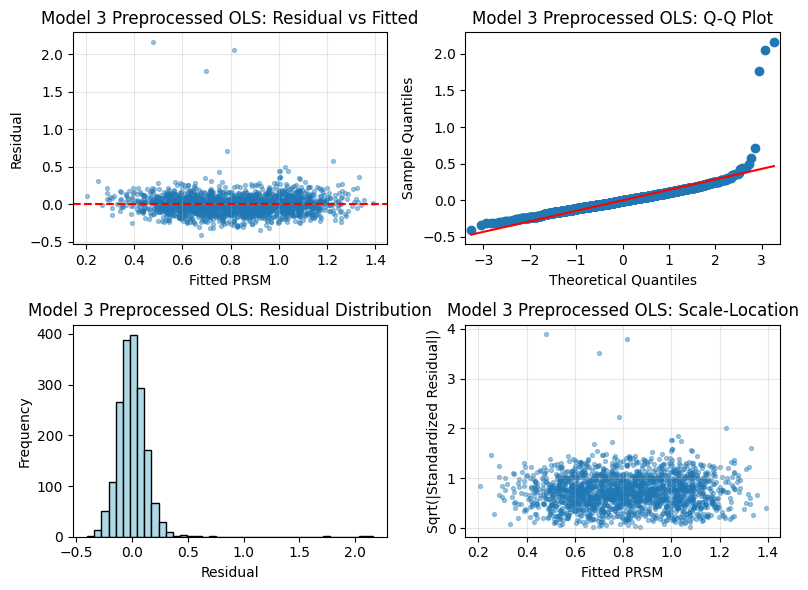

In [18]:
# Model 3: Preprocessed OLS (with log transformation)
preprocessed_predictors = ['FICO_category', 'log_TotalAmtOwed', 'log_Volume', 'Stress', 'log_Months',
                   'Num_CreditLines', 'Prop_Delinquent_Credit', 'WomanOwned',
                   'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner',
                   'NAICS_ind_Retail Trade']

X_train_preprocessed = train_df[preprocessed_predictors].copy().astype(float)
X_train_preprocessed_with_const = sm.add_constant(X_train_preprocessed)
X_dev_preprocessed = dev_df[preprocessed_predictors].copy().astype(float)
X_dev_preprocessed_with_const = sm.add_constant(X_dev_preprocessed)

model_preOLS, metrics_preOLS = fit_ols_model(X_train_preprocessed_with_const, y_train, 'Model 3 Preprocessed OLS, log predictors')

preOLS_r2 = metrics_preOLS['r2']
preOLS_adj_r2 = metrics_preOLS['adj_r2']

model3_train_table = pd.DataFrame([metrics_preOLS['train_metrics']])
display_table(model3_train_table, 'Table M3A. Model 3 training metrics')

residuals_preOLS = model_preOLS.resid
fitted_preOLS = model_preOLS.fittedvalues
plot_residuals_diagnostics(residuals_preOLS, fitted_preOLS, 'Model 3 Preprocessed OLS', color='lightblue')


**Table M3B**

,Metric,Value
0,ResidualThreshold,0.500
1,OutlierCount,5.000
2,TrainRowsBeforeTrim,1807.000


**Table M3C**

,Index,Actual_PRSM,Predicted_PRSM,Residual,Abs_Residual
0,49.000,2.640,0.479,2.161,2.161
2,866.000,2.867,0.816,2.051,2.051
4,1152.000,2.467,0.699,1.768,1.768
3,952.000,1.495,0.784,0.711,0.711
1,134.000,1.806,1.225,0.580,0.580


**Table M3D**

,Model,TrainR2,TrainAdjR2,ParamCount
0,Model 3 Trimmed Preprocessed OLS,0.784,0.783,12.000


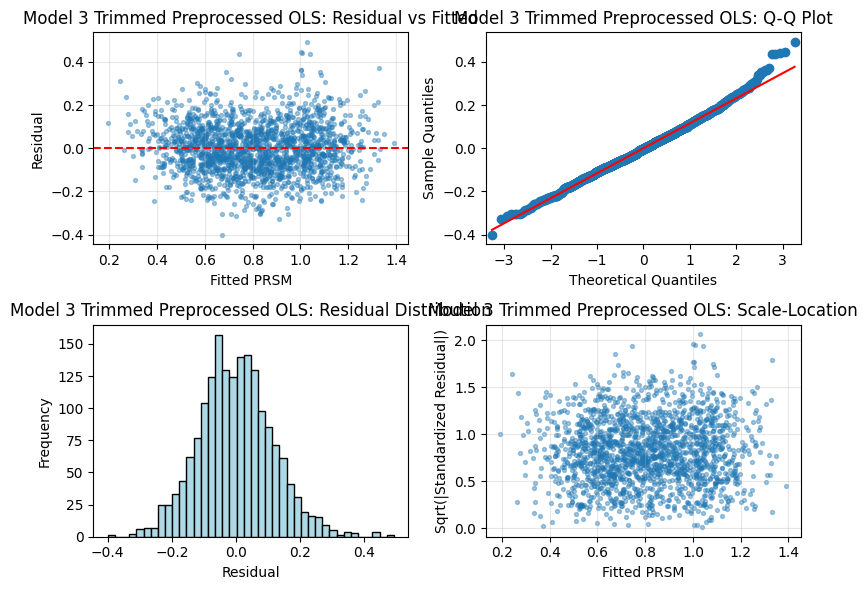

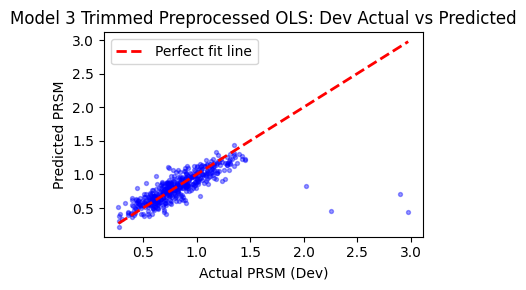

**Table M3E**

,Model,DevRMSE,DevMAE,PI95Coverage,IntervalMethod
0,Model 3 Trimmed Preprocessed OLS,0.222,0.112,0.938,OLS observation interval


In [19]:
# Model 3 refinement: outlier trimming for preprocessed OLS
outlier_pre_threshold = 0.5
abs_residuals = np.abs(residuals_preOLS)
outlier_mask = abs_residuals > outlier_pre_threshold
outlier_indices = np.where(outlier_mask)[0]

model3_outlier_summary = pd.DataFrame({
    'Metric': ['ResidualThreshold', 'OutlierCount', 'TrainRowsBeforeTrim'],
    'Value': [outlier_pre_threshold, len(outlier_indices), len(X_train_preprocessed)],
})
display_table(model3_outlier_summary, 'Table M3B')

if len(outlier_indices) > 0:
    outlier_data = pd.DataFrame({
        'Index': outlier_indices,
        'Actual_PRSM': y_train.iloc[outlier_indices].values,
        'Predicted_PRSM': fitted_preOLS.iloc[outlier_indices].values,
        'Residual': residuals_preOLS.iloc[outlier_indices].values,
        'Abs_Residual': abs_residuals.iloc[outlier_indices].values
    }).sort_values('Abs_Residual', ascending=False).head(20)
else:
    outlier_data = pd.DataFrame(columns=['Index', 'Actual_PRSM', 'Predicted_PRSM', 'Residual', 'Abs_Residual'])
display_table(outlier_data, 'Table M3C')

inlier_mask = (~outlier_mask).values
X_train_preprocessed_del = X_train_preprocessed[inlier_mask].copy().astype(float)
X_train_preprocessed_with_const_del = sm.add_constant(X_train_preprocessed_del)
y_train_preprocessed_del = y_train[inlier_mask].copy().astype(float)

model_preOLS_del, metrics_preOLS_del = fit_ols_model(X_train_preprocessed_with_const_del, y_train_preprocessed_del, 'Model 3 Trimmed Preprocessed OLS')

preOLS_del_r2 = metrics_preOLS_del['r2']
preOLS_del_adj_r2 = metrics_preOLS_del['adj_r2']

model3_trim_train_table = pd.DataFrame([metrics_preOLS_del['train_metrics']]).round(3)
display_table(model3_trim_train_table, 'Table M3D')

residuals_preOLS_del = model_preOLS_del.resid
fitted_preOLS_del = model_preOLS_del.fittedvalues
plot_residuals_diagnostics(residuals_preOLS_del, fitted_preOLS_del, 'Model 3 Trimmed Preprocessed OLS', color='lightblue')

rmse_preOLS_del, mae_preOLS_del, coverage_preOLS_del, metrics_m3_dev = validate_on_dev_set(
    model_preOLS_del, X_dev_preprocessed_with_const, y_dev, 'Model 3 Trimmed Preprocessed OLS', 'blue', model_type='OLS')

model3_dev_table = pd.DataFrame([metrics_m3_dev]).round(3)
display_table(model3_dev_table, 'Table M3E')




## Model 4: Preprocessed Stepwise OLS
```
PRSM ~ FICO_category + log_TotalAmtOwed + log_Volume + Stress + log_Months + 
        Num_CreditLines + Prop_Delinquent_Credit  + WomanOwned + 
       CorpStructure_Corp + CorpStructure_LLC + CorpStructure_Partner + NAICS_Retail Trade
```

Stepwise on log predictors removes nothing (Table M4B/C); dev RMSE 0.222 (Table M4D) matches Model 3 and remains above baseline. No performance win relative to simpler Model 3.


**Table M4A**

,Model,TrainR2,TrainAdjR2,ParamCount
0,Model 4 Preprocessed Stepwise OLS,0.784,0.783,12.000


**Table M4B**

,InitialPredictorCount,FinalPredictorCount,InitialCVRMSE,FinalCVRMSE,RemovedPredictors
0,12.000,12.000,0.117,0.117,None


**Table M4C**

,predictor,coef
0,FICO_category,0.056
1,log_TotalAmtOwed,0.104
2,log_Volume,-0.018
3,Stress,0.388
4,log_Months,0.077
5,Num_CreditLines,-0.001
6,Prop_Delinquent_Credit,-0.028
7,WomanOwned,0.278
8,CorpStructure_Corp,0.033
9,CorpStructure_LLC,0.245


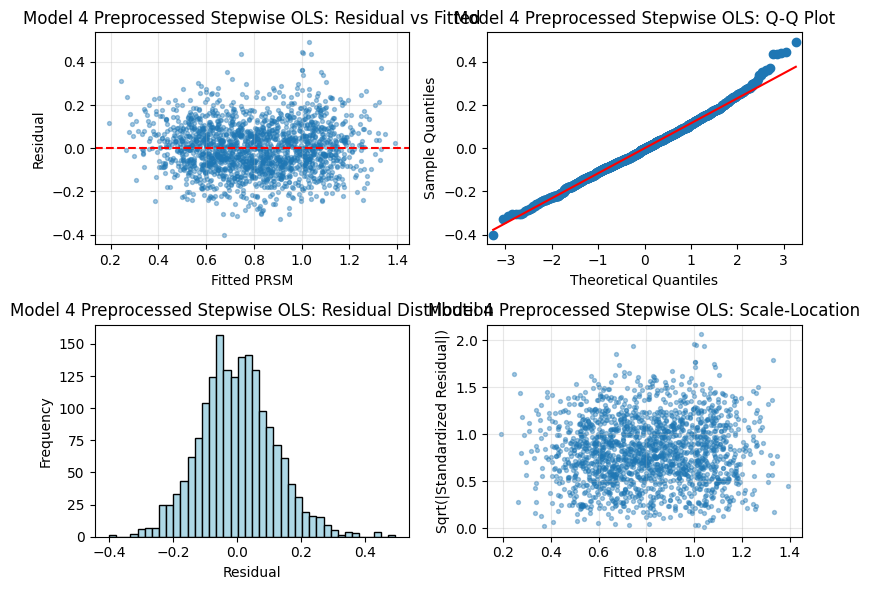

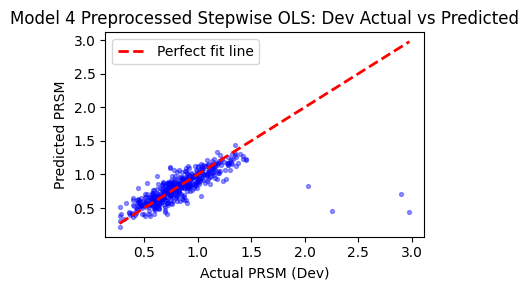

**Table M4D**

,Model,DevRMSE,DevMAE,PI95Coverage,IntervalMethod
0,Model 4 Preprocessed Stepwise OLS,0.222,0.112,0.938,OLS observation interval


In [20]:
# Model 4: Preprocessed Stepwise OLS (with log transformation)
stepwise_predictors_preStep, model_preStep, stepwise_summary_pre = backward_stepwise_selection(
    X_train_preprocessed_with_const_del, y_train_preprocessed_del, threshold_p=0.05)

preStep_r2 = model_preStep.rsquared
preStep_adj_r2 = model_preStep.rsquared_adj

model4_train_table = pd.DataFrame([{
    'Model': 'Model 4 Preprocessed Stepwise OLS',
    'TrainR2': preStep_r2,
    'TrainAdjR2': preStep_adj_r2,
    'ParamCount': int(model_preStep.df_model),
}]).round(3)
display_table(model4_train_table, 'Table M4A')

stepwise_summary_pre = stepwise_summary_pre.round(3)
display_table(stepwise_summary_pre, 'Table M4B')

stepwise_pre_coef_table = (
    model_preStep.params
    .drop('const', errors='ignore')
    .rename('coef')
    .reset_index()
    .rename(columns={'index': 'predictor'})
).round(3)
display_table(stepwise_pre_coef_table, 'Table M4C')

residuals_preStep = model_preStep.resid
fitted_preStep = model_preStep.fittedvalues
plot_residuals_diagnostics(residuals_preStep, fitted_preStep, 'Model 4 Preprocessed Stepwise OLS', color='lightblue')

X_dev_preStep = dev_df[stepwise_predictors_preStep].copy().astype(float)
X_dev_preStep = sm.add_constant(X_dev_preStep)

rmse_preStep, mae_preStep, coverage_preStep, metrics_m4_dev = validate_on_dev_set(
    model_preStep, X_dev_preStep, y_dev, 'Model 4 Preprocessed Stepwise OLS', 'blue', model_type='OLS')

model4_dev_table = pd.DataFrame([metrics_m4_dev]).round(3)
display_table(model4_dev_table, 'Table M4D')




## Model 5: Preprocessed LASSO
```
PRSM ~ FICO_category + log_TotalAmtOwed + log_Volume + Stress + log_Months + 
        Num_CreditLines + Prop_Delinquent_Credit  + WomanOwned + 
       CorpStructure_Corp + CorpStructure_LLC + CorpStructure_Partner + NAICS_Retail Trade
```
LASSO on log predictors keeps key dummies (Table M5B) but dev RMSE 0.222 (Table M5C) still lags baseline track. Conclusion: among log-track models, shrinkage does not close the gap to baseline OLS.


**Table M5A**

,Model,TrainR2,TrainAdjR2,ParamCount,OptimalAlpha
0,"Model 5 Preprocessed LASSO, log predictors",0.784,0.783,12.000,0.000


**Table M5B**

,Predictor,Coefficient,AbsCoefficient
7,WomanOwned,0.139,0.139
9,CorpStructure_LLC,0.105,0.105
1,log_TotalAmtOwed,0.095,0.095
10,CorpStructure_Partner,0.071,0.071
0,FICO_category,0.055,0.055
3,Stress,0.044,0.044
4,log_Months,0.020,0.020
2,log_Volume,-0.017,0.017
8,CorpStructure_Corp,0.014,0.014
11,NAICS_ind_Retail Trade,-0.002,0.002


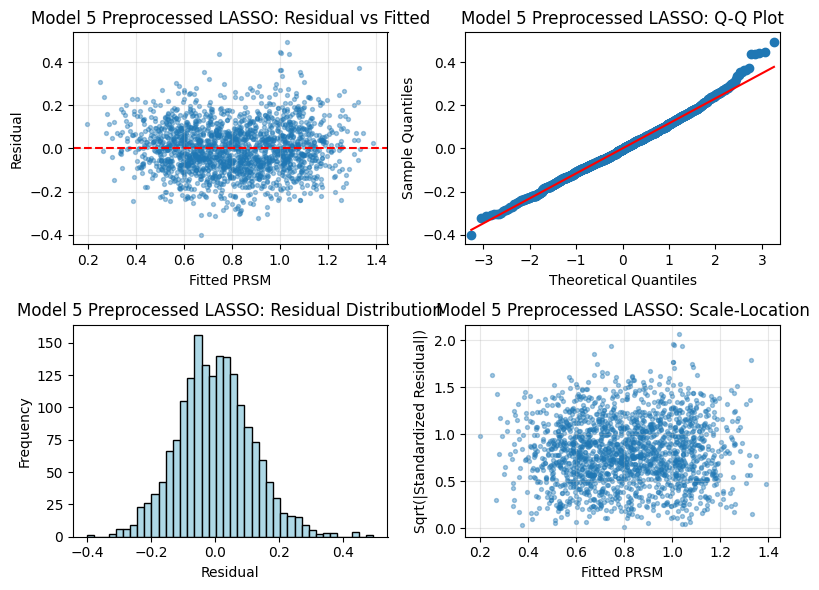

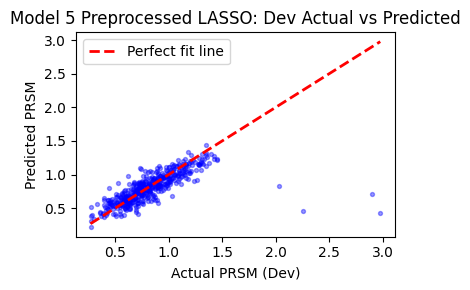

**Table M5C**

,Model,DevRMSE,DevMAE,PI95Coverage,IntervalMethod
0,Model 5 Preprocessed LASSO,0.222,0.112,0.938,Residual-quantile interval


In [21]:
# Model 5: Preprocessed LASSO (with log transformation)
model_preLASSO, scaler_preLASSO, metrics_preLASSO = fit_lasso_model(
    X_train_preprocessed_del, y_train_preprocessed_del, preprocessed_predictors, 'Model 5 Preprocessed LASSO, log predictors'
)

preLASSO_r2 = metrics_preLASSO['r2']
preLASSO_adj_r2 = metrics_preLASSO['adj_r2']
lasso_coefs_preLASSO = metrics_preLASSO['coefficients']

model5_train_table = pd.DataFrame([metrics_preLASSO['train_metrics']]).round(3)
display_table(model5_train_table, 'Table M5A')

model5_coef_table = lasso_coefs_preLASSO[lasso_coefs_preLASSO['Coefficient'] != 0].copy().round(3)
display_table(model5_coef_table, 'Table M5B')

X_train_preLASSO_scaled = scaler_preLASSO.transform(X_train_preprocessed_del)
y_pred_train_preLASSO = model_preLASSO.predict(X_train_preLASSO_scaled)

residuals_preLASSO = y_train_preprocessed_del - y_pred_train_preLASSO
fitted_preLASSO = y_pred_train_preLASSO
plot_residuals_diagnostics(residuals_preLASSO, fitted_preLASSO, 'Model 5 Preprocessed LASSO', color='lightblue')

X_dev_preLASSO_scaled = scaler_preLASSO.transform(X_dev_preprocessed)
rmse_preLASSO, mae_preLASSO, coverage_preLASSO, metrics_m5_dev = validate_on_dev_set(
    model_preLASSO, X_dev_preLASSO_scaled, y_dev, 'Model 5 Preprocessed LASSO', 'blue',
    model_type='LASSO', train_residuals=metrics_preLASSO['train_residuals']
)

model5_dev_table = pd.DataFrame([metrics_m5_dev]).round(3)
display_table(model5_dev_table, 'Table M5C')




## Model Comparison and Final Selection

Table 6 reports model metrics at full precision. The primary selection criterion is minimum dev RMSE. If dev RMSE is tied, Table 6A breaks the tie using the smallest absolute gap between PI95 coverage and the nominal 95% level.


In [22]:
# Comprehensive comparison table
comparison = pd.DataFrame({
    'Model': [
        'Baseline OLS (Trimmed)',
        'Baseline LASSO',
        'Baseline Stepwise OLS',
        'Preprocessed OLS (Trimmed)',
        'Preprocessed Stepwise OLS',
        'Preprocessed LASSO'
    ],
    'Track': ['NoLog', 'NoLog', 'NoLog', 'Log', 'Log', 'Log'],
    'TrainR2': [baselineOLS_del_r2, baselineLASSO_r2, baselineStep_r2, preOLS_del_r2, preStep_r2, preLASSO_r2],
    'AdjR2': [baselineOLS_del_adj_r2, baselineLASSO_adj_r2, baselineStep_adj_r2, preOLS_del_adj_r2, preStep_adj_r2, preLASSO_adj_r2],
    'DevRMSE': [rmse_baselineOLS_del, rmse_baselineLASSO, rmse_baselineStep, rmse_preOLS_del, rmse_preStep, rmse_preLASSO],
    'DevMAE': [mae_baselineOLS_del, mae_baselineLASSO, mae_baselineStep, mae_preOLS_del, mae_preStep, mae_preLASSO],
    'PI95CovPct': [
        coverage_baselineOLS_del * 100,
        coverage_baselineLASSO * 100,
        coverage_baselineStep * 100,
        coverage_preOLS_del * 100,
        coverage_preStep * 100,
        coverage_preLASSO * 100
    ],
})

comparison['PI95GapAbs'] = (comparison['PI95CovPct'] - 95.0).abs()
comparison = comparison.sort_values(['DevRMSE', 'PI95GapAbs', 'DevMAE'], ascending=[True, True, True]).reset_index(drop=True)

# Primary criterion: minimum DevRMSE; tie-breaker: closest PI95 coverage to 95%; then smaller DevMAE.
best_rmse_idx = 0

# Show full-precision table for transparent model ranking
comparison_view = comparison.copy()
display_table(comparison_view, 'Table 6. Model comparison (ranked by DevRMSE, then PI95GapAbs, then DevMAE)', digits=6)

selection_summary = pd.DataFrame([{
    'SelectedModel': comparison.loc[best_rmse_idx, 'Model'],
    'PrimaryCriterion': 'Minimum DevRMSE',
    'TieBreaker1': 'Minimum |PI95CovPct - 95|',
    'TieBreaker2': 'Minimum DevMAE',
    'SelectedDevRMSE': comparison.loc[best_rmse_idx, 'DevRMSE'],
    'SelectedPI95CovPct': comparison.loc[best_rmse_idx, 'PI95CovPct'],
    'SelectedDevMAE': comparison.loc[best_rmse_idx, 'DevMAE'],
}])
display_table(selection_summary, 'Table 6A. Final model selection summary', digits=6)


**Table 6. Model comparison (ranked by DevRMSE, then PI95GapAbs, then DevMAE)**

,Model,Track,TrainR2,AdjR2,DevRMSE,DevMAE,PI95CovPct,PI95GapAbs
0,Baseline LASSO,NoLog,0.826344,0.825180,0.216622,0.102911,95.132743,0.132743
1,Baseline OLS (Trimmed),NoLog,0.826416,0.825253,0.216799,0.102916,94.911504,0.088496
2,Baseline Stepwise OLS,NoLog,0.826416,0.825253,0.216799,0.102916,94.911504,0.088496
3,Preprocessed OLS (Trimmed),Log,0.784348,0.782902,0.222413,0.111527,93.805310,1.194690
4,Preprocessed Stepwise OLS,Log,0.784348,0.782902,0.222413,0.111527,93.805310,1.194690
5,Preprocessed LASSO,Log,0.784320,0.782873,0.222426,0.111607,93.805310,1.194690


**Table 6A. Final model selection summary**

,SelectedModel,PrimaryCriterion,TieBreaker1,TieBreaker2,SelectedDevRMSE,SelectedPI95CovPct,SelectedDevMAE
0,Baseline LASSO,Minimum DevRMSE,Minimum |PI95CovPct - 95|,Minimum DevMAE,0.216622,95.132743,0.102911


## Prediction on Evaluation Set

Table 7A records the selected model and output file metadata. Table 7 presents a preview of predicted PRSM and 95% prediction intervals for evaluation records.


In [26]:
# Final model prediction on evaluation data (point + 95% PI)
final_model_name = comparison.loc[best_rmse_idx, 'Model']

prediction_specs = {
    'Baseline OLS (Trimmed)': {
        'model_type': 'OLS',
        'model': model_baselineOLS_del,
        'predictors': base_predictors,
        'train_residuals': model_baselineOLS_del.resid,
    },
    'Baseline LASSO': {
        'model_type': 'LASSO',
        'model': model_baselineLASSO,
        'scaler': scaler_baselineLASSO,
        'predictors': base_predictors,
        'train_residuals': metrics_baselineLASSO['train_residuals'],
    },
    'Baseline Stepwise OLS': {
        'model_type': 'OLS',
        'model': model_baselineStep,
        'predictors': stepwise_predictors_baselineStep,
        'train_residuals': model_baselineStep.resid,
    },
    'Preprocessed OLS (Trimmed)': {
        'model_type': 'OLS',
        'model': model_preOLS_del,
        'predictors': preprocessed_predictors,
        'train_residuals': model_preOLS_del.resid,
    },
    'Preprocessed Stepwise OLS': {
        'model_type': 'OLS',
        'model': model_preStep,
        'predictors': stepwise_predictors_preStep,
        'train_residuals': model_preStep.resid,
    },
    'Preprocessed LASSO': {
        'model_type': 'LASSO',
        'model': model_preLASSO,
        'scaler': scaler_preLASSO,
        'predictors': preprocessed_predictors,
        'train_residuals': metrics_preLASSO['train_residuals'],
    },
}

selected_spec = prediction_specs[final_model_name]
eval_df = pd.read_csv('./test_df.csv')
X_eval = eval_df[selected_spec['predictors']].astype(float)

if selected_spec['model_type'] == 'OLS':
    X_eval_with_const = sm.add_constant(X_eval, has_constant='add')
    point_prediction = selected_spec['model'].predict(X_eval_with_const)

    pred_summary = selected_spec['model'].get_prediction(X_eval_with_const).summary_frame(alpha=0.05)
    pi_lower_95 = pred_summary['obs_ci_lower'].to_numpy()
    pi_upper_95 = pred_summary['obs_ci_upper'].to_numpy()
else:
    X_eval_scaled = selected_spec['scaler'].transform(X_eval)
    point_prediction = selected_spec['model'].predict(X_eval_scaled)

    abs_resid_95pct = np.quantile(np.abs(np.asarray(selected_spec['train_residuals'])), 0.95)
    pi_lower_95 = point_prediction - abs_resid_95pct
    pi_upper_95 = point_prediction + abs_resid_95pct

prediction_output = pd.DataFrame({
    'pred': point_prediction,
    'pi95_lo': pi_lower_95,
    'pi95_hi': pi_upper_95,
})
prediction_output.to_csv('./predictions.csv', index=False)

prediction_meta = pd.DataFrame([{
    'SelectedModel': final_model_name,
    'RowsPredicted': len(prediction_output),
    'OutputFile': 'predictions.csv',
}])
display_table(prediction_meta, 'Table 7A')

preview_table = prediction_output.head(10).copy()
display_table(preview_table, 'Table 7')




**Table 7A**

,SelectedModel,RowsPredicted,OutputFile
0,Baseline LASSO,2500.000,predictions.csv


**Table 7**

,pred,pi95_lo,pi95_hi
0,0.511,0.304,0.718
1,0.813,0.606,1.020
2,0.411,0.204,0.618
3,0.727,0.520,0.934
4,0.956,0.749,1.162
5,1.007,0.800,1.214
6,0.942,0.735,1.149
7,1.158,0.951,1.365
8,0.964,0.757,1.171
9,0.591,0.384,0.798


## Interpretation for Decision Support

Table 7A reports baseline prediction level and practical-effect threshold. Table 8 lists baseline borrower values. Table 9 reports practically important drivers and directions. Table 10 reports statistically detectable but practically small effects.


In [24]:
# Executive summary prep: baseline borrower + main drivers
practical_effect_threshold = 0.03

interpretation_specs = {
    'Baseline OLS (Trimmed)': {
        'model_type': 'OLS',
        'model': model_baselineOLS_del,
        'scaler': None,
        'predictors': base_predictors,
        'train_X': X_train_base_del,
        'train_y': y_train_base_del,
    },
    'Baseline LASSO': {
        'model_type': 'LASSO',
        'model': model_baselineLASSO,
        'scaler': scaler_baselineLASSO,
        'predictors': base_predictors,
        'train_X': X_train_base_del,
        'train_y': y_train_base_del,
    },
    'Baseline Stepwise OLS': {
        'model_type': 'OLS',
        'model': model_baselineStep,
        'scaler': None,
        'predictors': stepwise_predictors_baselineStep,
        'train_X': X_train_base_del[stepwise_predictors_baselineStep],
        'train_y': y_train_base_del,
    },
    'Preprocessed OLS (Trimmed)': {
        'model_type': 'OLS',
        'model': model_preOLS_del,
        'scaler': None,
        'predictors': preprocessed_predictors,
        'train_X': X_train_preprocessed_del,
        'train_y': y_train_preprocessed_del,
    },
    'Preprocessed Stepwise OLS': {
        'model_type': 'OLS',
        'model': model_preStep,
        'scaler': None,
        'predictors': stepwise_predictors_preStep,
        'train_X': X_train_preprocessed_del[stepwise_predictors_preStep],
        'train_y': y_train_preprocessed_del,
    },
    'Preprocessed LASSO': {
        'model_type': 'LASSO',
        'model': model_preLASSO,
        'scaler': scaler_preLASSO,
        'predictors': preprocessed_predictors,
        'train_X': X_train_preprocessed_del,
        'train_y': y_train_preprocessed_del,
    },
}

selected_spec = interpretation_specs[final_model_name]
X_train_used = selected_spec['train_X'].copy()
y_train_used = selected_spec['train_y'].copy()


def round_for_profile(value: float) -> float:
    if abs(value) >= 100:
        return round(value, 0)
    if abs(value) >= 10:
        return round(value, 1)
    return round(value, 2)


def is_binary(series: pd.Series) -> bool:
    return set(np.unique(series.dropna())).issubset({0, 1})


baseline_profile = {}
for predictor in selected_spec['predictors']:
    series = X_train_used[predictor].dropna()
    if is_binary(series):
        baseline_profile[predictor] = int(series.mode().iloc[0])
    else:
        baseline_profile[predictor] = round_for_profile(float(series.median()))

baseline_df = pd.DataFrame([baseline_profile])[selected_spec['predictors']]

if selected_spec['model_type'] == 'OLS':
    coef_series = selected_spec['model'].params.drop('const', errors='ignore')
    pval_series = selected_spec['model'].pvalues.drop('const', errors='ignore')

    coefficient_table = pd.DataFrame({
        'predictor': coef_series.index,
        'coef': coef_series.values,
        'p_value': pval_series.reindex(coef_series.index).values,
    })
    baseline_pred = float(
        selected_spec['model']
        .predict(sm.add_constant(baseline_df, has_constant='add'))
        .iloc[0]
    )
else:
    original_scale_coef = selected_spec['model'].coef_ / selected_spec['scaler'].scale_
    coefficient_table = pd.DataFrame({
        'predictor': selected_spec['predictors'],
        'coef': original_scale_coef,
    })
    coefficient_table = coefficient_table[coefficient_table['coef'] != 0].copy()

    aux_X = sm.add_constant(X_train_used[coefficient_table['predictor']], has_constant='add')
    aux_ols = sm.OLS(y_train_used, aux_X).fit()
    aux_pvals = (
        aux_ols.pvalues
        .drop('const', errors='ignore')
        .rename('p_value')
        .reset_index()
        .rename(columns={'index': 'predictor'})
    )
    coefficient_table = coefficient_table.merge(aux_pvals, on='predictor', how='left')

    baseline_pred = float(
        selected_spec['model'].predict(selected_spec['scaler'].transform(baseline_df))[0]
    )

coefficient_table['StatSig5pct'] = coefficient_table['p_value'] < 0.05


def get_interpretation_step(series: pd.Series, baseline_value: float):
    if is_binary(series):
        if baseline_value == 0:
            return 1.0, '0 to 1'
        return -1.0, '1 to 0'

    iqr = float(series.quantile(0.75) - series.quantile(0.25))
    std = float(series.std())
    raw_step = iqr if iqr > 0 else (0.5 * std if std > 0 else 1.0)
    step = round_for_profile(raw_step)

    if step == 0:
        step = 1.0
    return step, f'+{step}'


rows = []
for _, row in coefficient_table.iterrows():
    predictor = row['predictor']
    coef = float(row['coef'])
    series = X_train_used[predictor].dropna()

    step, step_note = get_interpretation_step(series, baseline_profile[predictor])
    delta_prsm = coef * step

    rows.append({
        'Predictor': predictor,
        'ScenarioChange': step_note,
        'EstimatedDeltaPRSM': delta_prsm,
        'Direction': 'higher risk' if delta_prsm > 0 else 'lower risk',
        'PValue': row['p_value'],
        'StatSig5pct': bool(row['StatSig5pct']),
        'Practical': abs(delta_prsm) >= practical_effect_threshold,
    })


driver_table = pd.DataFrame(rows).sort_values(
    'EstimatedDeltaPRSM',
    key=lambda col: np.abs(col),
    ascending=False,
)
main_drivers = driver_table[driver_table['Practical']].copy()
stat_not_practical = driver_table[
    driver_table['StatSig5pct']
    & (~driver_table['Practical'])
].copy()

summary_table = pd.DataFrame({
    'Metric': ['BaselinePredictedPRSM', 'PracticalEffectThreshold'],
    'Value': [baseline_pred, practical_effect_threshold],
}).round(3)
baseline_table = pd.DataFrame({
    'Predictor': baseline_df.columns,
    'BaselineValue': baseline_df.iloc[0].values,
}).round(3)
main_drivers_view = main_drivers[['Predictor', 'ScenarioChange', 'EstimatedDeltaPRSM', 'Direction', 'PValue', 'StatSig5pct']].round(3)
stat_not_practical_view = stat_not_practical[['Predictor', 'ScenarioChange', 'EstimatedDeltaPRSM', 'PValue']].round(3)
display_table(summary_table, 'Table 7A. Interpretation summary metrics')
display_table(baseline_table, 'Table 8. Baseline borrower profile')
display_table(main_drivers_view, 'Table 9. Practically important drivers')
display_table(stat_not_practical_view, 'Table 10. Statistically detectable but practically small effects')





**Table 7A. Interpretation summary metrics**

,Metric,Value
0,BaselinePredictedPRSM,0.547
1,PracticalEffectThreshold,0.030


**Table 8. Baseline borrower profile**

,Predictor,BaselineValue
0,FICO_category,2.000
1,TotalAmtOwed,194674.000
2,Volume,84626.000
3,Stress,0.190
4,Num_CreditLines,10.000
5,Prop_Delinquent_Credit,0.400
6,WomanOwned,0.000
7,Months,18.000
8,CorpStructure_Corp,0.000
9,CorpStructure_LLC,0.000


**Table 9. Practically important drivers**

,Predictor,ScenarioChange,EstimatedDeltaPRSM,Direction,PValue,StatSig5pct
6,WomanOwned,0 to 1,0.279,higher risk,0.000,True
9,CorpStructure_LLC,0 to 1,0.243,higher risk,0.000,True
10,CorpStructure_Partner,0 to 1,0.172,higher risk,0.000,True
0,FICO_category,+2.0,0.110,higher risk,0.000,True
1,TotalAmtOwed,+200985.0,0.100,higher risk,0.000,True
3,Stress,+0.15,0.070,higher risk,0.000,True


**Table 10. Statistically detectable but practically small effects**

,Predictor,ScenarioChange,EstimatedDeltaPRSM,PValue
8,CorpStructure_Corp,0 to 1,0.028,0.000
7,Months,+6.0,0.013,0.000
